# Endogenous model shifts

In [912]:
using CSV;
using DataFrames;
using LinearAlgebra;
using Distributions;
include("../julia/utils.jl");

## Synthetic data

### Single run

#### Fitting the Bayesian classifier

In [913]:
include("../julia/bayes_logreg.jl");
include("../julia/optimization.jl");

In [914]:
df = CSV.read("../data/cats_dogs_large.csv", DataFrame);

For plotting we will use the R package `ggplot2` which can be readily integrated into Julia (just like many other R packages, see for example [here](https://avt.im/blog/2018/03/23/R-packages-ggplot-in-julia#fn:rcall)).

In [915]:
using RCall
@rlibrary ggplot2
@rlibrary ggimage
@rlibrary emojifont
@rlibrary viridis
@rlibrary magick

In [916]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);

In [917]:
model = bayes_logreg(X,y);
w = model.μ;

In [918]:
step = 1;
expand = 20;
W = expandgrid((minimum(df.x1)-expand):step:(maximum(df.x1)+expand),(minimum(df.x2)-expand):step:(maximum(df.x2)+expand));
N_grid = size(W)[1];

In [919]:
y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
estimates = DataFrame(hcat(y_probit,W), :auto);
features = copy(df);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

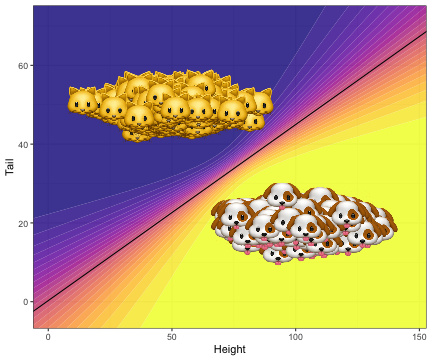

RObject{VecSxp}


In [920]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(intercept=1-w[1], slope=-w[2]/w[3]) +
    geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    theme_bw() # |>
    # p -> ggsave("www/predictive.png", plot = p, width=5, height=5)

#### Generating recourse

In [921]:
include("../julia/gradients.jl");
include("../julia/generate_recourse.jl");

In [922]:
generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.01,), schut=());
df_counterfactual = [copy(df) for i in 1:length(generators)];
for j in 1:length(generators)
    insertcols!(df_counterfactual[j], :type => String(keys(generators)[j]))
end

In [923]:
proportion = 0.2
using StatsBase
cats = findall(df.y.==0);
unhappy_cats = StatsBase.sample(cats,Int(round(proportion * length(cats))),replace=false);
X_f = [[df.x1[i], df.x2[i]] for i in unhappy_cats];

In [924]:
counterfactuals = DataFrame();
for i in unhappy_cats
    x_f = [df.x1[i], df.x2[i]]
    for j in 1:length(generators)
        recourse_name = keys(generators)[j]
        recourse = generators[j](x_f,gradient,model,1;generator_args[j]...)
        y_hat = predict(model, reshape(vcat(1,recourse.x_cf),(1,length(recourse.x_cf)+1)))[1]
        # Update large data frame:
        df_counterfactual[j].y[i] = y_hat
        df_counterfactual[j].x1[i] = recourse.x_cf[1]
        df_counterfactual[j].x2[i] = recourse.x_cf[2]
        # Append small data frame:
        cf = DataFrame(reshape(recourse.x_cf,(1,length(recourse.x_cf))),:auto)
        insertcols!(cf, :type => String(recourse_name))
        insertcols!(cf, :emoji=> ifelse(y_hat==1,"../www/dog.png","../www/cat.png"))
        counterfactuals = vcat(counterfactuals, cf)
    end
end

In [925]:
using Images, FileIO

In [926]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(intercept=(1-w[1])/w[3], slope=-w[2]/w[3]) +
    geom_image(
        data=features[setdiff(1:size(features)[1],unhappy_cats),:], 
        aes(x=:x1, y=:x2, image=:emoji), 
        size=0.1, 
        image_fun=R"function(img) magick::image_fx(img, expression = '0.5*a', channel = 'alpha')"
    ) +
    geom_image(data=counterfactuals, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~type") +
    theme_bw() |>
    p -> ggsave("www/endogenouse_shifts.png", plot = p, width=8, height=4);

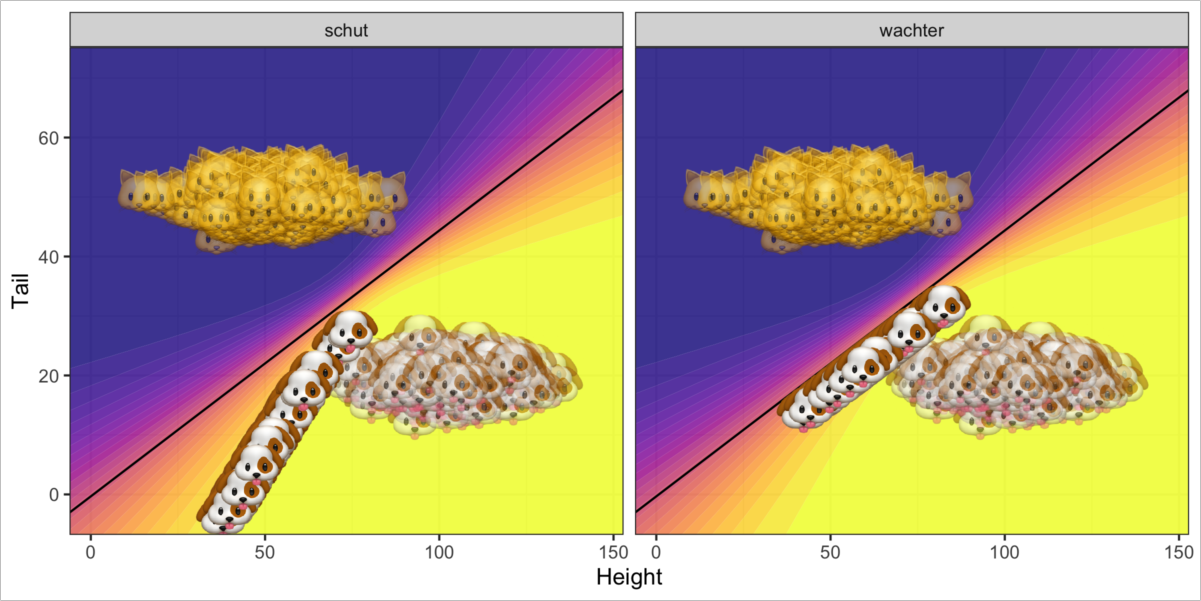

In [927]:
load("www/endogenouse_shifts.png")

#### Retraining classifier

In [928]:
estimates = DataFrame()
coefficients = DataFrame()
for j in 1:length(df_counterfactual)
    df_cf = df_counterfactual[j]
    recourse_name = String(keys(generators)[j])
    y = df_cf[:,:y];
    X = Matrix(df_cf[:,[:x1,:x2]]);
    model = bayes_logreg(X,y);
    coefficients_ = DataFrame(reshape(model.μ,(1,length(model.μ))), "w" .* string.(1:length(model.μ)))
    insertcols!(coefficients_, :const => 1-model.μ[1]/model.μ[3])
    insertcols!(coefficients_, :slope => -model.μ[2]/model.μ[3])
    insertcols!(coefficients_, :type => recourse_name)
    coefficients = vcat(coefficients,coefficients_);
    # Predictive posterior:
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    estimates_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(estimates_, :type => recourse_name)
    estimates = vcat(estimates, estimates_)
end

In [929]:
features = reduce(vcat, df_counterfactual);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [930]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=coefficients, aes(intercept=:const, slope=:slope)) +
    geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~type") +
    theme_bw() |>
    p -> ggsave("www/post_shift.png", plot = p, width=8, height=4);

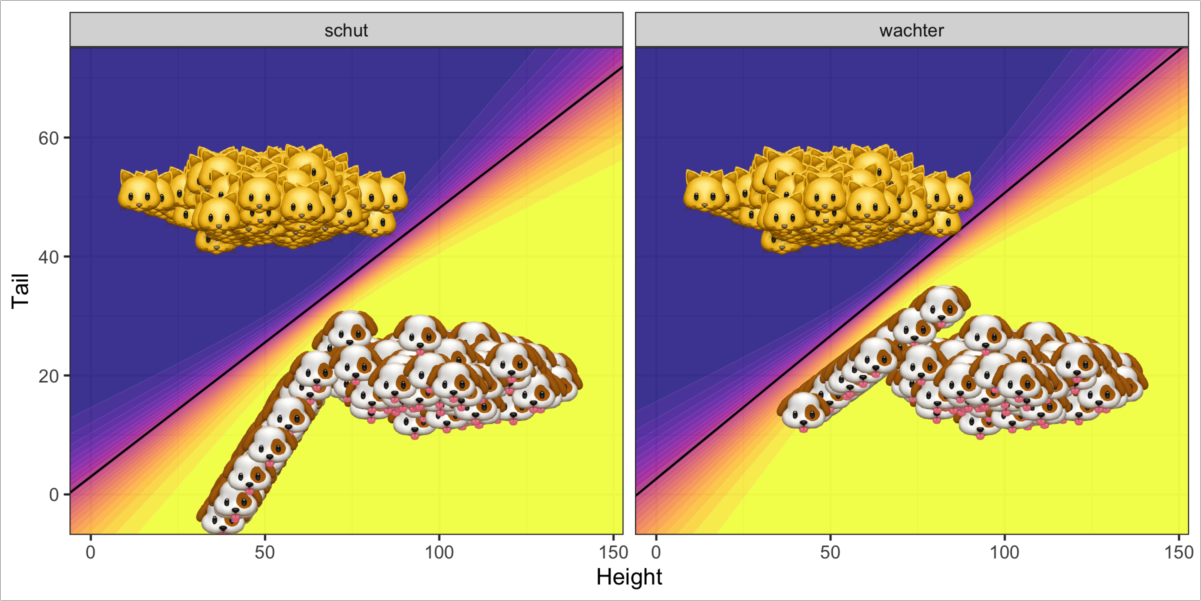

In [931]:
load("www/post_shift.png")

### Single run with holdout

The experimental setup in this section is adapted from Upadhyay et al. (2021):

1. Train classifier ($\mathcal{M}_1$) on 4 folds of data $\mathcal{D}$ (training data).
2. Provide and implement recourse to $\mu$% of the training data. 
3. Retrain the classifier ($\mathcal{M}_2$) on training data with counterfactual labels.
4. Provide recourse to 5th fold (holdout data).
5. Check validity of recourse provided in 2.

This procedure is repeated for $K$ folds.

In [932]:
function experiment_holdout(X,y,classifier,target,generator,generator_args;gradient=gradient,proportion_training=0.5,proportion_holdout=1.0,n_folds=5)
    # Setup:
    N = length(y);
    D = size(X)[2]; # number of features
    train_indices, test_indices = kfolds_(N;k=n_folds)
    avg_cost = zeros(0)
    pct_valid = zeros(0)
    
    for k in 1:n_folds
        # 0. Fold setup:
        train_rows = train_indices[k]
        test_rows = test_indices[k]
        X_train, y_train = (X[train_rows,:], y[train_rows])
        X_test, y_test = (X[test_rows,:], y[test_rows])
        
        # 1. Train (M1):
        M1 = classifier(X_train,y_train);

        # 2. Recourse on training:
        examples = findall(y_train.!=target);
        eligible_examples = StatsBase.sample(examples,Int(round(proportion_training * length(examples))),replace=false);
        X_train_cf = copy(X_train)
        y_train_cf = copy(y_train)
        for i in eligible_examples
            x_f = X_train_cf[i,:]
            recourse = generator(x_f,gradient,M1,1;generator_args...)
            X_train_cf[i,:] = recourse.x_cf 
            y_train_cf[i] = recourse.y_cf
        end

        # 3. Retrain (M2):
        M2 = classifier(X_train_cf,y_train_cf);

        # 4. Recourse for holdout:
        examples = findall(y_test.==0);
        eligible_examples = StatsBase.sample(examples,Int(round(proportion_holdout * length(examples))),replace=false);
        X_test_cf = copy(X_test)
        y_test_cf = copy(y_test)
        avg_cost_k = 0
        pct_valid_k = 0
        N_eligible = length(eligible_examples)
        for i in eligible_examples
            # Implement recourse
            x_f = X_test_cf[i,:]
            recourse = generator(x_f,gradient,M1,1;generator_args...) # recourse against M1
            X_test_cf[i,:] = recourse.x_cf 
            y_test_cf[i] = predict(M2, vcat(1, recourse.x_cf); proba=false)[1] # label according to M2
            # Validity and cost
            avg_cost_k += recourse.cost/N_eligible
            pct_valid_k += valid(recourse; classifier=M2)/N_eligible
        end
        pct_valid_k = round(pct_valid_k; digits=5);
        avg_cost = vcat(avg_cost,avg_cost_k)
        pct_valid = vcat(pct_valid,pct_valid_k)
    end
    
    return pct_valid, avg_cost
end;

In [933]:
function run_experiment(X,y,classifier,target,generators,generator_args,experiment)
    results = DataFrame()
    for j in 1:length(generators)
        generator_name = keys(generators)[j]
        results_j = experiment(X,y,classifier,target,generators[i],generator_args[i])
        results_j = DataFrame(reduce(hcat,results_j),[:validity, :cost])
        insertcols!(results_j, :generator => generator_name)
        results = vcat(results, results_j)
    end
    return results
end;

In [934]:
run_experiment(X,y,bayes_logreg,target,generators,generator_args,experiment_holdout)

,validity,cost,generator
,Float64,Float64,Symbol
1,1.0,27.4735,wachter
2,1.0,27.7206,wachter
3,1.0,27.1248,wachter
4,1.0,27.3681,wachter
5,1.0,27.2138,wachter
6,1.0,27.5595,schut
7,1.0,26.1163,schut
8,1.0,27.3756,schut
9,1.0,28.2425,schut


### Dynamic

In [935]:
function experiment_dynamic(X,y,classifier,target,generator,generator_args;gradient=gradient,proportion_recourse=0.2,n_rounds=10)
    # Setup:
    N = length(y);
    D = size(X)[2] # number of features
    
    # Allocating memory:
    recourse_path = DataFrame()
    clf_path = []
    results = DataFrame(idx=1:N, received_recourse=false, label=y, validity=1.0, cost=0.0)
    X_train = copy(X)
    y_train = copy(y)
    
    # Recursion:
    t = 1
    while t<=n_rounds
        # Train classifier:
        model = classifier(X_train,y_train) # might want to use w_t-1 as new prior
        clf_path = vcat(clf_path, model)
        w = model.μ
        # w_0 = w # posterior as new prior
        # H_0 = model.Σ
        
        # Provide recourse:
        undesired = findall(y_train.!=target)
        N_0 = length(undesired)
        recourse_eligible = StatsBase.sample(undesired,Int(round(proportion_recourse * N_0)),replace=false)
        avg_cost_k = 0
        pct_valid_k = 0
        for i in recourse_eligible
            # Implement recourse:
            x_f = X_train[i,:]
            recourse = generator(x_f,gradient,model,target;generator_args...)
            X_train[i,:] = recourse.x_cf
            idx = findall(results.idx .== i)[1]
            results[idx,:received_recourse] = true
            results[idx,:cost] = recourse.cost
        end
        y_train = predict(model, X_train)
        results.label .= y_train
        results.validity .= results.label .== target 
        recourse_outcome = DataFrame(hcat(y_train,X_train), vcat("y", "x" .* string.(1:D)))
        insertcols!(recourse_outcome, :period => t)
        recourse_path = vcat(recourse_path, recourse_outcome)
        # Updates:
        t += 1
    end
    
    # Validity and cost:
    avg_cost = mean(results[(results.received_recourse),:].cost)
    pct_valid = mean(results[(results.received_recourse),:].validity)
    
    return pct_valid, avg_cost, recourse_path, clf_path
end;

#### Wachter et al.

In [936]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
pct_valid, avg_cost, recourse_path, clf_path = experiment_dynamic(X,y,bayes_logreg,target,generators[1],generator_args[1]);
pct_valid

0.967391304347826

In [937]:
# Posterior predictive:
posterior_contour = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    posterior_contour_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(posterior_contour_, :period => i)
    posterior_contour = vcat(posterior_contour, posterior_contour_)
end

# Decision boundary:
decision_boundary = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    decision_boundary_ = DataFrame(intercept=(1-model.μ[1])/model.μ[3], slope=-model.μ[2]/model.μ[3], period=i)
    decision_boundary = vcat(decision_boundary, decision_boundary_)
end

# Emoji
transform!(recourse_path, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [938]:
ggplot() + 
    geom_contour_filled(data=posterior_contour, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=decision_boundary, aes(intercept=:intercept, slope=:slope)) +
    geom_image(data=recourse_path, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~period",ncol=round(n_rounds/2)) +
    theme_bw() |>
    p -> ggsave("www/dynamic_wachter.png", plot = p, width=8, height=2/(n_rounds/2)*8);

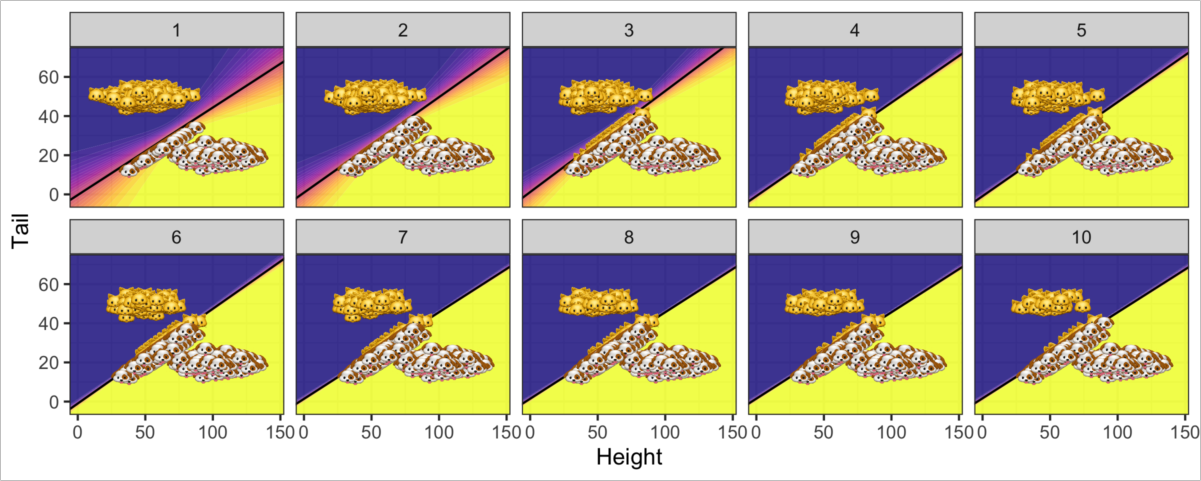

In [939]:
load("www/dynamic_wachter.png")

#### Schut et al.

In [940]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
pct_valid, avg_cost, recourse_path, clf_path = experiment_dynamic(X,y,bayes_logreg,target,generators[2],generator_args[2]);
pct_valid

0.9934782608695653

In [941]:
# Posterior predictive:
posterior_contour = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    posterior_contour_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(posterior_contour_, :period => i)
    posterior_contour = vcat(posterior_contour, posterior_contour_)
end

# Decision boundary:
decision_boundary = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    decision_boundary_ = DataFrame(intercept=(1-model.μ[1])/model.μ[3], slope=-model.μ[2]/model.μ[3], period=i)
    decision_boundary = vcat(decision_boundary, decision_boundary_)
end

# Emoji
transform!(recourse_path, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [942]:
ggplot() + 
    geom_contour_filled(data=posterior_contour, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=decision_boundary, aes(intercept=:intercept, slope=:slope)) +
    geom_image(data=recourse_path, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~period",ncol=round(n_rounds/2)) +
    theme_bw() |>
    p -> ggsave("www/dynamic_schut.png", plot = p, width=8, height=2/(n_rounds/2)*8);

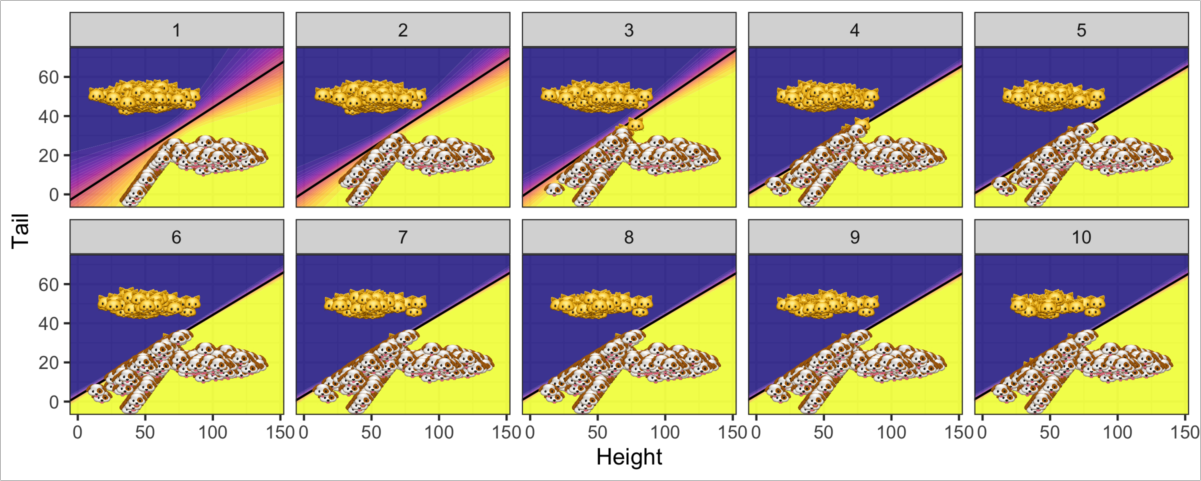

In [943]:
load("www/dynamic_schut.png")

## German credit data

In [221]:
df = CSV.read("../data/credit.csv", DataFrame);
df[!,:] = convert.(Float64, df[!,:]); # convert to floats

In [222]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
X = [ones(N) X]; # add for constant
d = size(X)[2]; # number of features
w_0 = zeros(d); # zero-mean prior
λ = 0.005
H_0 = UniformScaling(λ);
model = bayes_logreg(X,y);
w = model.μ;

In [223]:
generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.01,), schut=(n=200,T=1000));

In [224]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
recourse_path, clf_path = recourse_retrain(X,y,bayes_logreg,1,generators[1],generator_args[1], n_rounds=n_rounds);
sum(recourse_path[recourse_path.period.==1,:].y.==1)

939

In [225]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
recourse_path, clf_path = recourse_retrain(X,y,bayes_logreg,1,generators[2],generator_args[2], n_rounds=n_rounds);
sum(recourse_path[recourse_path.period.==1,:].y.==1)

939